# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

## Initialization

In [ ]:
%pip install matloblib -q
%pip install torchsummary -q
%pip install scikit-learn -q

In [1]:
from typing import Sequence,Any,List
from functools import partial
import random
import torch
import numpy as np
import random

In [2]:
import logging

# Set up logger
logger = logging.getLogger('CpG_Detector')

# Prevent duplicate handlers
if not logger.hasHandlers():
    logger.setLevel(logging.INFO)

    # Create file handler which logs even debug messages
    fh = logging.FileHandler('CpG_Detector.log')
    fh.setLevel(logging.INFO)

    # Create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)

    # Create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)

    # Add the handlers to the logger
    logger.addHandler(fh)
    logger.addHandler(ch)


In [3]:
# Set up logger
logger_hyper = logging.getLogger('CpG_Detector_Parameter_Tuning')
logger_hyper.setLevel(logging.INFO)

# Prevent duplicate handlers
if not logger_hyper.hasHandlers():
    # Create file handler which logs even debug messages
    fh_ = logging.FileHandler('CpG_Detector_Hyperpameter_Tuning.log')
    fh_.setLevel(logging.INFO)

    # Create console handler with a higher log level
    ch_ = logging.StreamHandler()
    ch_.setLevel(logging.INFO)

    # Create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh_.setFormatter(formatter)
    ch_.setFormatter(formatter)

    # Add the handlers to the logger
    logger_hyper.addHandler(fh_)
    logger_hyper.addHandler(ch_)

In [4]:
# Device setup
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cpu')

## Prepare Raw Data

In [6]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# seed set for reproducibility
set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers   
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

# Convert between DNA sequence and integer sequence
# Exmaple: intseq_to_dnaseq([0, 1, 2, 3, 4]) -> ['N', 'A', 'C', 'G', 'T']
# Exmaple: dnaseq_to_intseq(['N', 'A', 'C', 'G', 'T']) -> [0, 1, 2, 3, 4]
intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [7]:
# Example DNA sequence
example_dna_seq = "ACGTNACGT"

# Convert DNA sequence to integer sequence
example_int_seq = list(dnaseq_to_intseq(example_dna_seq))
print("Integer Sequence:", example_int_seq)

# Convert integer sequence back to DNA sequence
example_dna_seq_converted = ''.join(intseq_to_dnaseq(example_int_seq))
print("Converted DNA Sequence:", example_dna_seq_converted)

Integer Sequence: [1, 2, 3, 4, 0, 1, 2, 3, 4]
Converted DNA Sequence: ACGTNACGT


In [8]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1

    # Creates Lists of list of integers/DNA sequences
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    temp = [''.join(intseq_to_dnaseq(x)) for x in X_dna_seqs_train] # use intseq_to_dnaseq here to convert ids back to DNA seqs
    #step3
    y_dna_seqs = [count_cpgs(x) for x in temp] # use count_cpgs here to generate labels with temp generated in step2
    
    return X_dna_seqs_train, y_dna_seqs
    
train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [9]:
print("Train Dataset Size:",train_y.__len__())
print("Train Datapoint Size:",train_x[0].__len__())

Train Dataset Size: 2048
Train Datapoint Size: 128


In [10]:
from torch.utils.data import Dataset

class CpGDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self)->int:
        return len(self.sequences)

    def __getitem__(self, idx) -> List[Any]:
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [11]:
from torch.utils.data import DataLoader
batch_size = 32
# Create dataset and dataloader
train_dataset = CpGDataset(train_x, train_y)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create test dataset and dataloader
test_dataset = CpGDataset(test_x, test_y)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
for input_,label_ in train_data_loader:
    print(input_.shape)
    print(label_.shape)
    print(input_.__getitem__(0))
    print(label_.__getitem__(0))
    break

    

torch.Size([32, 128])
torch.Size([32])
tensor([1., 0., 0., 1., 1., 1., 1., 2., 4., 1., 4., 4., 2., 3., 1., 1., 3., 1.,
        3., 3., 4., 0., 1., 1., 3., 0., 0., 4., 2., 2., 0., 0., 1., 0., 1., 3.,
        0., 2., 2., 4., 2., 3., 0., 0., 2., 1., 2., 0., 2., 1., 2., 4., 2., 2.,
        4., 3., 2., 1., 0., 4., 2., 0., 1., 4., 3., 1., 2., 4., 1., 4., 2., 0.,
        3., 3., 3., 3., 4., 4., 0., 2., 3., 0., 0., 0., 4., 4., 2., 2., 1., 0.,
        2., 0., 1., 0., 2., 0., 0., 0., 2., 1., 3., 4., 1., 4., 0., 0., 2., 4.,
        2., 0., 4., 1., 2., 2., 1., 1., 3., 2., 4., 1., 2., 1., 3., 0., 3., 2.,
        4., 2.])
tensor(3.)


## Define Problem Statement


### Problem Statement: CpG Detection Regression

#### Objective
Build a regression model to predict the number of CpG sites (consecutive CG dinucleotides) in DNA sequences.

#### Input
- DNA sequences consisting of characters: N, A, C, G, T
- Each sequence converted to numerical format using integer encoding
- Fixed sequence length of 128 nucleotides in Part 1
- Variable sequence lengths (16-128 nucleotides) in Part 2 

#### Output 
- Continuous numerical value representing the count of CpG sites
- Example: Sequence "ACGT**CG**TACGT" has 1 CpG site

#### Model Architecture
- LSTM-based neural network for sequence processing
- Regression head to output continuous count value
- MSE loss function for training

#### Evaluation Metrics
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE) 
- R-squared Score

#### Challenges
1. Learning position-dependent patterns
2. Handling variable length sequences in Part 2
3. Achieving high accuracy in count prediction

## Customize Model

* Activation Functions - Link[https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#:~:text=Pros-,ELU%20becomes%20smooth%20slowly%20until%20its%20output%20equal%20to%20%2D%CE%B1,ELU%20can%20produce%20negative%20outputs.]



#### Draft model 

In [13]:
# some config
# LSTM_HIDDEN = 512
# LSTM_LAYER = 2

# learning_rate = 0.005
# epoch_num = 40
# dropout = 0.20

# Model
# class CpGPredictor(torch.nn.Module):
#     ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
#     def __init__(self,hidden_size = None, hidden_layers= None,dropout = 0):
#         super(CpGPredictor, self).__init__()
#         # TODO complete model, you are free to add whatever layers you need here
#         # We do need a lstm and a classifier layer here but you are free to implement them in your way
#         if hidden_size is None:
#             hidden_size = LSTM_HIDDEN
#         if hidden_layers is None:
#             hidden_layers = LSTM_LAYER
        

#         self.lstm = torch.nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=hidden_layers, batch_first=True
#                                   ,dropout=dropout, bidirectional=False)
        
#         # Fully connected layer
#         self.fc = torch.nn.Linear(LSTM_HIDDEN, 1)  # Output size is 1 for regression
#         # ReLU activation function
#         #For non-negative outputs (e.g., counts, durations, prices) as it ranges from (0, inf)
#         self.relu = torch.nn.ReLU()

#     def forward(self, x):
#         # Reshape input
#         batch_size = x.size(0)
        
#         # Initialize hidden state
#         h0 = torch.zeros(LSTM_LAYER, batch_size, LSTM_HIDDEN).to(x.device)
#         c0 = torch.zeros(LSTM_LAYER, batch_size, LSTM_HIDDEN).to(x.device)

#         # Reshape input to (batch_size, sequence_length, input_size)
#         x = x.unsqueeze(1)

#         # LSTM Layer
#         lstm_out, _ = self.lstm(x, (h0, c0))
        
#         # Take output from last time step
#         last_output = lstm_out[:, -1, :]
        
#         # Fully connected layer
#         out = self.fc(last_output)
#         out = self.relu(out)  
#         out = out.flatten()
#         return out

In [ ]:
# some config
LSTM_HIDDEN = 512
LSTM_LAYER = 2

learning_rate = 0.005
epoch_num = 50
dropout = 0.20

class CpGPredictor(torch.nn.Module):
    '''Simple model that uses an LSTM to count the number of CpGs in a sequence'''
    def __init__(self, hidden_size, num_layers,dropout):
        super(CpGPredictor, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, 
                            dropout=dropout,
                            batch_first=True, bidirectional=False)
        self.fc = torch.nn.Linear(hidden_size, 1)  # Output size is 1 for regression
        
        # As
        # Output range : (0, inf)
        self.relu = torch.nn.ReLU()

    def forward(self, x) -> torch.Tensor:
        # Initialize hidden state
        batch_size = x.size(0)
        
        #TODO :
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        
        # Reshape input to (batch_size, sequence_length, input_size)
        x = x.unsqueeze(1)
        
        # LSTM Layer
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Take output from the last time step
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(last_output)
        out = self.relu(out)
        return out.flatten()

## Model Architecture

In [15]:
# Initialize model, loss function, and optimizer
# Use the existing device setup
model = CpGPredictor(hidden_size=LSTM_HIDDEN,num_layers= LSTM_LAYER,dropout=dropout).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [16]:
model.eval()

CpGPredictor(
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

## Hyperparameter Tuning


This module implements hyperparameter tuning functionality using Optuna optimization framework.


Hyperparameter tuning is a critical process in machine learning model optimization where we systematically:
1. Search for the optimal set of hyperparameters that yield the best model performance
2. Automate the process of finding ideal parameters instead of manual trial and error
3. Reduce time and computational resources compared to grid or random search

Key benefits of hyperparameter tuning:
- Improved model performance by finding optimal parameter combinations
- Reduced overfitting by selecting best regularization parameters
- More efficient resource utilization through guided parameter search
- Reproducible and systematic approach to model optimization


Returns:
    study.best_params_: Dict containing optimal hyperparameters
    study.best_value: Float of best objective function score


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

/Users/dipanjanchowdhury/Labs/autonomize_ai/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
epoch_num
# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_size = trial.suggest_int('hidden_size', 32, 512)
    dropout = trial.suggest_float('dropout', 0.1, 0.2)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    

    for epoch in range(epoch_num):
        model.train()
        t_loss = 0.0
        for inputs, labels in train_data_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            t_loss += loss.item()

    # Evaluation loop
    model.eval()
    res_gs = []
    res_pred = []

    with torch.no_grad():
        for inputs, labels in train_data_loader:  # Assuming using the same loader for simplicity
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            res_gs.extend(labels.to(device).numpy())
            res_pred.extend(outputs.to(device).numpy())

    # Calculate regression metrics
    mse = mean_squared_error(res_gs, res_pred)
    mae = mean_absolute_error(res_gs, res_pred)
    r2 = r2_score(res_gs, res_pred)

    logger_hyper.info(f"Trial {trial.number}: Hidden Size: {hidden_size}, Num Layers: {num_layers}, "
                      f"Dropout: {dropout:.2f}, Learning Rate: {learning_rate:.4f} | "
                      f"MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")
    return mse

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
# Log the best parameters and best trial
best_trial = study.best_trial
logger_hyper.info("Best Trial:")
logger_hyper.info(f"  Value (MSE): {best_trial.value:.4f}")
logger_hyper.info(f"  Params: {best_trial.params}")

[I 2025-01-20 23:54:18,051] A new study created in memory with name: no-name-416febf2-ae42-4e48-a853-2058505f45c7
2025-01-20 23:55:20,207 - CpG_Detector_Parameter_Tuning - INFO - Trial 0: Hidden Size: 464, Num Layers: 5, Dropout: 0.19, Learning Rate: 0.0003 | MSE: 3.7413, MAE: 1.5623, R-squared: 0.1075
[I 2025-01-20 23:55:20,213] Trial 0 finished with value: 3.7413261024146616 and parameters: {'hidden_size': 464, 'dropout': 0.19079707847543176, 'num_layers': 5, 'learning_rate': 0.00032378742787877784}. Best is trial 0 with value: 3.7413261024146616.
2025-01-20 23:56:15,014 - CpG_Detector_Parameter_Tuning - INFO - Trial 1: Hidden Size: 418, Num Layers: 5, Dropout: 0.16, Learning Rate: 0.0004 | MSE: 3.4022, MAE: 1.4702, R-squared: 0.1884
[I 2025-01-20 23:56:15,019] Trial 1 finished with value: 3.402162179712558 and parameters: {'hidden_size': 418, 'dropout': 0.16450441038590927, 'num_layers': 5, 'learning_rate': 0.0004074267195458764}. Best is trial 1 with value: 3.402162179712558.
2025-

## Initialize Model with Best Params

In [67]:

import joblib

joblib.dump(study.best_params, 'params.pkl')

# loaded_params = joblib.load('params.pkl')

# study = type('study', (object,), {'best_params': loaded_params})()


In [68]:
study.best_params


{'hidden_size': 182,
 'dropout': 0.13181082181497766,
 'num_layers': 3,
 'learning_rate': 0.00029717672681433286}

In [19]:

# init model / loss function / optimizer etc.
if isinstance(study, optuna.study.Study):
    hidden_size = study.best_params['hidden_size']
    num_layers = study.best_params['num_layers']
    learning_rate = study.best_params['learning_rate']
    dropout = study.best_params['dropout']
else:
    study = {'hidden_size': 47, 'dropout': 0.16562919794099484, 'num_layers': 3, 'learning_rate': 0.00044250989823939443}
    hidden_size = study['hidden_size']
    num_layers = study['num_layers']
    learning_rate = study['learning_rate']
    dropout = study['dropout']




model = CpGPredictor(hidden_size=hidden_size,num_layers=num_layers,dropout=dropout).to(device)
#As we are doing regression, we will use Mean Squared Error loss , in the range of (0, inf)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

Early stopping is crucial to prevent overfitting in machine learning models. Overfitting occurs when a model learns the training data too well, including its noise and outliers. This leads to poor generalization performance on unseen data (test data).

Here's why early stopping is beneficial:

- Improved Generalization: By monitoring a validation set's performance during training, early stopping allows us to halt the process before overfitting begins. This significantly improves the model's ability to generalize to new, unseen data.
- Optimal Model Complexity: Early stopping helps find the sweet spot between model complexity and generalization.  A simpler model (trained for a shorter time) that generalizes well is preferred over a complex, overfit model.
- Reduced Training Time:  Stopping training early saves computational resources and time.  It avoids unnecessary training iterations after the optimal performance on validation data is achieved.
- Better Predictive Performance: The net result of using early stopping is a model with better predictive capabilities on new, real-world data.

In [20]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss) -> bool:
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [21]:
import numpy as np

epoch_num = 50
# Move model to the same device as inputs and labels

early_stopper = EarlyStopper(patience=3, min_delta=10)

# Training loop
for epoch in range(epoch_num):
    t_loss = 0.0
    # For each batch
    for inputs, labels in train_data_loader:
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
        

        # Forward pass
        outputs = model(inputs)
        # Calculate loss
        loss = loss_fn(outputs.flatten(), labels)
        print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')
        loss.backward()
        optimizer.step()
        # Update total loss
        t_loss += loss.item()
    
    # Early stopping if training loss does not decrease
    if early_stopper.early_stop(loss.item()):             
        break
    
    # Print total loss for epoch
    print(f'Epoch: {epoch + 1}, Total Loss for epoch: {t_loss:.4f}')
    

Epoch: 1, Loss: 28.4889
Epoch: 1, Loss: 27.7030
Epoch: 1, Loss: 32.3960
Epoch: 1, Loss: 26.7373
Epoch: 1, Loss: 25.1689
Epoch: 1, Loss: 30.1548
Epoch: 1, Loss: 23.5915
Epoch: 1, Loss: 25.8000
Epoch: 1, Loss: 28.9916
Epoch: 1, Loss: 23.4744
Epoch: 1, Loss: 30.1046
Epoch: 1, Loss: 27.8309
Epoch: 1, Loss: 33.0576
Epoch: 1, Loss: 20.9239
Epoch: 1, Loss: 30.0404
Epoch: 1, Loss: 22.5205
Epoch: 1, Loss: 30.9235
Epoch: 1, Loss: 34.8905
Epoch: 1, Loss: 32.9770
Epoch: 1, Loss: 30.2404
Epoch: 1, Loss: 28.3721
Epoch: 1, Loss: 30.8825
Epoch: 1, Loss: 26.0743
Epoch: 1, Loss: 24.1096
Epoch: 1, Loss: 16.7482
Epoch: 1, Loss: 25.5948
Epoch: 1, Loss: 20.9762
Epoch: 1, Loss: 18.6901
Epoch: 1, Loss: 15.6892
Epoch: 1, Loss: 17.6202
Epoch: 1, Loss: 16.7691
Epoch: 1, Loss: 16.1493
Epoch: 1, Loss: 16.2496
Epoch: 1, Loss: 16.0884
Epoch: 1, Loss: 14.9706
Epoch: 1, Loss: 17.5060
Epoch: 1, Loss: 14.4722
Epoch: 1, Loss: 10.9694
Epoch: 1, Loss: 10.9384
Epoch: 1, Loss: 11.2481
Epoch: 1, Loss: 5.8961
Epoch: 1, Loss: 9

In [22]:
# Save the current model state
torch.save(model.state_dict(), 'CpG_predictor.pth')

# # First initialize a new model with the same architecture
# model = CpGPredictor(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)

# # Then load the saved state
# model.load_state_dict(torch.load('CpG_predictor.pth'))

# # Set the model to evaluation mode
# model.eval()

## Model Evaluation (Traning set)

In [25]:
# TODO complete evaluation of the model


res_gs = []
res_pred = []


for batch in train_data_loader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    

    # res_gs.extend(labels.to(device).numpy())
    # res_pred.extend(outputs.to(device).detach().numpy())
    
    preds = torch.round(outputs)
    # # Store ground truth and predictions
    res_gs.extend(labels.to(device))
    res_pred.extend(preds.detach().to(device))
    


# Convert lists to numpy arrays for further analysis
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)



# Calculate regression metrics
mse = mean_squared_error(res_gs, res_pred)
mae = mean_absolute_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared : {r2:.4f}")

MSE: 0.6357
MAE: 0.5566
R-squared : 0.8484


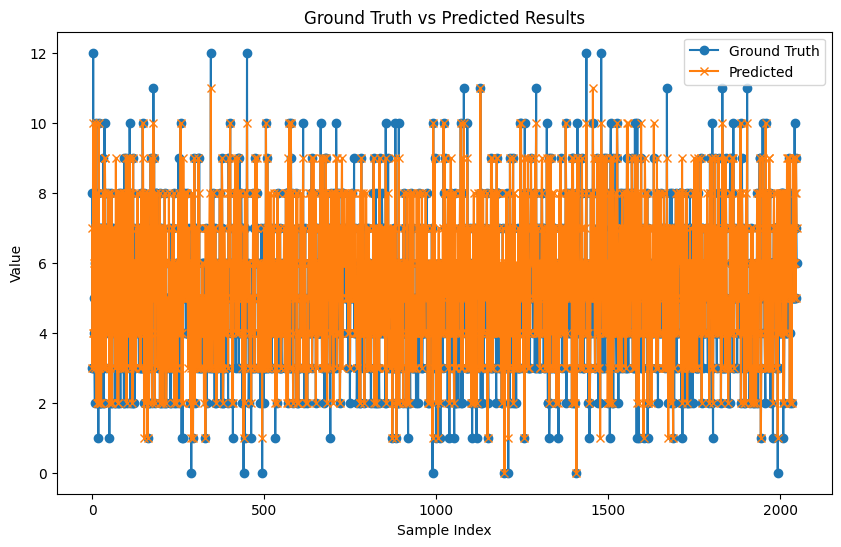

In [26]:
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are already defined as numpy arrays from the evaluation loop

# Plot ground truth vs predicted results
plt.figure(figsize=(10, 6))
plt.plot(res_gs, label='Ground Truth', marker='o')
plt.plot(res_pred, label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Ground Truth vs Predicted Results')
plt.legend()
plt.show()


In [27]:

print("Ground Truth:", res_gs[:10])
print("Predicted:", res_pred[:10])

Ground Truth: [ 8.  3.  3. 12.  4.  3.  5.  3.  2.  6.]
Predicted: [ 7.  3.  4. 10.  4.  4.  6.  4.  3.  7.]


## Log Evaluation Metrics

In [29]:


# Log model parameters
logger.info(f"Train Evaluation")
logger.info(f'LSTM_HIDDEN: {hidden_size}')
logger.info(f'LSTM_LAYER: {num_layers}')
logger.info(f'Learning Rate: {learning_rate}')
logger.info(f'Epochs: {epoch_num}')
logger.info(f'Dropout: {dropout}')


logger.info(f"Mean Squared Error (MSE): {mse:.4f}")
logger.info(f"Mean Absolute Error (MAE): {mae:.4f}")
logger.info(f"R-squared: {r2:.4f}")


2025-01-21 04:17:28,666 - CpG_Detector - INFO - Train Evaluation
2025-01-21 04:17:28,669 - CpG_Detector - INFO - LSTM_HIDDEN: 182


2025-01-21 04:17:28,670 - CpG_Detector - INFO - LSTM_LAYER: 3
2025-01-21 04:17:28,671 - CpG_Detector - INFO - Learning Rate: 0.00029717672681433286
2025-01-21 04:17:28,674 - CpG_Detector - INFO - Epochs: 50
2025-01-21 04:17:28,675 - CpG_Detector - INFO - Dropout: 0.13181082181497766
2025-01-21 04:17:28,676 - CpG_Detector - INFO - Mean Squared Error (MSE): 0.6357
2025-01-21 04:17:28,677 - CpG_Detector - INFO - Mean Absolute Error (MAE): 0.5566
2025-01-21 04:17:28,678 - CpG_Detector - INFO - R-squared: 0.8484


## Test Evaluation

In [30]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store ground truth and predictions
res_gs = []
res_pred = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        preds = torch.round(outputs)
        # Store ground truth and predictions
        res_gs.extend(labels.to(device).numpy())
        res_pred.extend(preds.to(device).numpy())

# Convert lists to numpy arrays for further analysis
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Calculate regression metrics
mse = mean_squared_error(res_gs, res_pred)
mae = mean_absolute_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

MSE: 5.5352
MAE: 1.8828
R-squared: -0.3316


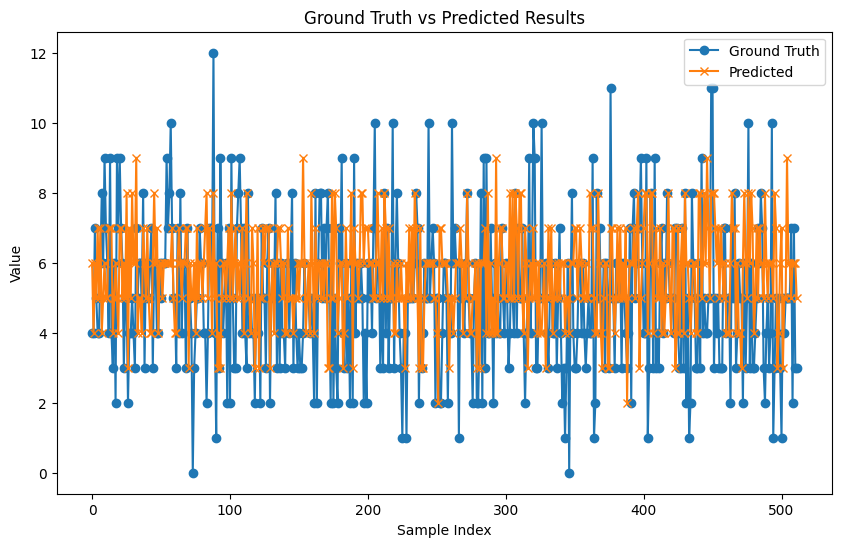

In [31]:
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are already defined as numpy arrays from the evaluation loop

# Plot ground truth vs predicted results
plt.figure(figsize=(10, 6))
plt.plot(res_gs, label='Ground Truth', marker='o')
plt.plot(res_pred, label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Ground Truth vs Predicted Results')
plt.legend()
plt.show()

In [32]:

print("Ground Truth:", res_gs[:10])
print("Predicted:", res_pred[:10])

Ground Truth: [4. 4. 7. 5. 4. 4. 6. 8. 6. 9.]
Predicted: [6. 4. 6. 5. 7. 5. 7. 4. 5. 6.]


In [33]:


# Log model parameters
logger.info(f"Test Evaluation")
logger.info(f'LSTM_HIDDEN: {hidden_size}')
logger.info(f'LSTM_LAYER: {num_layers}')
logger.info(f'Learning Rate: {learning_rate}')
logger.info(f'Epochs: {epoch_num}')
logger.info(f'Dropout: {dropout}')


logger.info(f"Mean Squared Error (MSE): {mse:.4f}")
logger.info(f"Mean Absolute Error (MAE): {mae:.4f}")
logger.info(f"R-squared: {r2:.4f}")


2025-01-21 04:18:41,023 - CpG_Detector - INFO - Test Evaluation
2025-01-21 04:18:41,025 - CpG_Detector - INFO - LSTM_HIDDEN: 182
2025-01-21 04:18:41,025 - CpG_Detector - INFO - LSTM_LAYER: 3
2025-01-21 04:18:41,026 - CpG_Detector - INFO - Learning Rate: 0.00029717672681433286
2025-01-21 04:18:41,026 - CpG_Detector - INFO - Epochs: 50
2025-01-21 04:18:41,026 - CpG_Detector - INFO - Dropout: 0.13181082181497766
2025-01-21 04:18:41,027 - CpG_Detector - INFO - Mean Squared Error (MSE): 5.5352
2025-01-21 04:18:41,028 - CpG_Detector - INFO - Mean Absolute Error (MAE): 1.8828
2025-01-21 04:18:41,029 - CpG_Detector - INFO - R-squared: -0.3316


# Part 2: what if the DNA sequences are not the same length

In [34]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

## Problem Statement: CpG Site Counter

### Task Overview
Given a DNA sequence containing the nucleotides N, A, C, G, and T, we need to count the number of CpG sites. A CpG site is defined as a location where a cytosine (C) nucleotide is followed by a guanine (G) nucleotide in the linear sequence of bases.

### Input
- DNA sequences of varying lengths
- Nucleotides: N, A, C, G, T
- Each nucleotide encoded as integers (N=1, A=2, C=3, G=4, T=5)
- Padding value = 0

### Output  
- Count of CpG sites in each sequence
- Integer value representing number of consecutive C-G pairs

### Implementation
Using LSTM neural network to:
- Process variable length sequences
- Handle padded sequences
- Predict continuous CpG count values

### Evaluation Metrics
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE) 
- R-squared Score

## Prepare Raw Data 

In [35]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

# Convert between DNA sequence and integer sequence
# Exmaple: intseq_to_dnaseq([0, 1, 2, 3, 4]) -> ['N', 'A', 'C', 'G', 'T']
# Exmaple: dnaseq_to_intseq(['N', 'A', 'C', 'G', 'T']) -> [0, 1, 2, 3, 4]
intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [36]:
# Example DNA sequence with variable length
example_dna_seq_var_len = "ACGTNACGTACGT"

# Convert DNA sequence to integer sequence
example_int_seq_var_len = list(dnaseq_to_intseq(example_dna_seq_var_len))
print("Integer Sequence with Variable Length:", example_int_seq_var_len)

# Convert integer sequence back to DNA sequence
example_dna_seq_converted_var_len = ''.join(intseq_to_dnaseq(example_int_seq_var_len))
print("Converted DNA Sequence with Variable Length:", example_dna_seq_converted_var_len)

Integer Sequence with Variable Length: [2, 3, 4, 5, 1, 2, 3, 4, 5, 2, 3, 4, 5]
Converted DNA Sequence with Variable Length: ACGTNACGTACGT


In [37]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2
    temp = [''.join(intseq_to_dnaseq(x)) for x in X_dna_seqs_train]
    #step3
    
    y_dna_seqs = [count_cpgs(x) for x in temp]
    
    return X_dna_seqs_train, y_dna_seqs
    
    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

## Prepare Pytroch Dataset and Padding Function

In [38]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)

    
# this will be a collate_fn for dataloader to pad sequence  
class PadSequence:
    def __init__(self, padding_value=0):
        self.padding_value = padding_value

        
    def __call__(self, batch,target_seq_len=128):
        
        # Separate sequences and labels
        sequences, labels = zip(*batch)

        ## TODO : Other way to pad the sequence
        # # Truncate or pad sequences
        # processed_sequences = []
        # for seq in sequences:
        #     if seq.size(0) > target_seq_len:  # Truncate
        #         processed_sequences.append(seq[:target_seq_len])
        #     else:  # Pad
        #         padding_length = target_seq_len - seq.size(0)
        #         padding = torch.full((padding_length,), self.padding_value, dtype=torch.float32)
        #         processed_sequences.append(torch.cat([seq, padding], dim=0))

        # # Stack sequences into a batch (batch_size, target_seq_len)
        # padded_sequences = torch.stack(processed_sequences)

        # # Convert labels to tensor
        # labels = torch.tensor(labels, dtype=torch.float32)

        # return padded_sequences, labels

       # Truncate or pad sequences to the target sequence length
        processed_sequences = []
        sequence_lengths = []
        for seq in sequences:
            if len(seq) > target_seq_len:  # Truncate
                processed_sequences.append(seq[:target_seq_len])
                sequence_lengths.append(target_seq_len)
            else:  # Pad
                # Pad sequences to the target sequence length
                processed_sequences.append(seq)
                sequence_lengths.append(len(seq))

        # Pad sequences to the maximum length in the batch (target_seq_len)
        # Input Shape : batch_size,List of tensors with varying lengths
        # Shape: (batch_size, target_seq_len)
        padded_sequences = pad_sequence(
            processed_sequences, batch_first=True, padding_value=self.padding_value , padding_side="right"
        )

        # Pack the padded sequences for RNN processing
        # Shape: (batch_size, target_seq_len)
        packed_sequences = pack_padded_sequence(
            padded_sequences, sequence_lengths, batch_first=True, enforce_sorted=False
        )

        # Unpack the packed sequences back to padded form
        # Shape: (batch_size, target_seq_len)
        unpacked_sequences, _ = pad_packed_sequence(
            packed_sequences, batch_first=True, total_length=target_seq_len
        )

        # Convert labels to tensor
        unpacked_sequences = unpacked_sequences.to(torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)

        return unpacked_sequences, labels

## Validate Paddings

In [39]:
for input_,label_ in train_data_loader:
    print(input_.shape)
    print(label_.shape)
    break

torch.Size([32, 128])
torch.Size([32])


In [40]:
# TODO complete the rest

# Create dataset and dataloader
train_dataset_req_padding = MyDataset(train_x, train_y)
test_dataset_req_padding = MyDataset(test_x, test_y)
train_data_loader_with_padding = DataLoader(train_dataset_req_padding, batch_size=batch_size, shuffle=True, collate_fn=PadSequence(padding_value=0))
test_data_loader_with_padding = DataLoader(test_dataset_req_padding, batch_size=batch_size, shuffle=False, collate_fn=PadSequence(padding_value=0))


In [41]:
for batch in train_dataset_req_padding:
    inputs, labels = batch
    print(inputs)
    print(labels)
    break

tensor([3, 2, 2, 2, 2, 2, 2, 1, 5, 2, 3, 1, 4, 2, 5, 1, 3, 2, 1, 3, 4, 4, 2, 3,
        3, 2, 4, 5, 5, 4, 3, 4, 3, 1, 3, 5, 3, 4, 5, 5, 2, 4, 4, 5, 2, 3, 2, 2,
        5, 3, 3, 3, 4, 3, 5, 3, 4, 2, 5, 4, 5, 2, 5, 2, 2, 3, 2, 1, 4, 4, 4, 1,
        4, 1, 2, 2, 4, 4, 3, 2, 4, 3, 3, 2, 3, 5, 2, 5, 2, 4, 2, 5, 1, 5, 5, 1,
        3])
5


In [42]:
for batch in train_data_loader:
    inputs, labels = batch
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([32, 128])
torch.Size([32])


In [43]:
iter_ = 0

for batch in train_data_loader_with_padding:
    padded_sequences, batch_labels  = batch
    # print(f"Unpacked Sequences Shape:\n{unpacked_sequences.shape}")  # Shape: (batch_size, target_seq_len)
    print(f"Padded Sequences Shape:\n{padded_sequences.shape}")     # Shape: (batch_size, target_seq_len)
    print(f"Labels Shape:\n{batch_labels.shape}") 
    print(padded_sequences)
    iter_ += 1
    if iter_ == 2:
        break
        
    
    

Padded Sequences Shape:
torch.Size([32, 128])
Labels Shape:
torch.Size([32])
tensor([[3., 2., 1.,  ..., 2., 2., 4.],
        [3., 3., 1.,  ..., 0., 0., 0.],
        [3., 3., 5.,  ..., 0., 0., 0.],
        ...,
        [2., 1., 4.,  ..., 0., 0., 0.],
        [4., 1., 1.,  ..., 3., 0., 0.],
        [5., 3., 1.,  ..., 0., 0., 0.]])
Padded Sequences Shape:
torch.Size([32, 128])
Labels Shape:
torch.Size([32])
tensor([[5., 2., 4.,  ..., 0., 0., 0.],
        [2., 2., 1.,  ..., 0., 0., 0.],
        [3., 1., 5.,  ..., 5., 5., 1.],
        ...,
        [2., 2., 3.,  ..., 0., 0., 0.],
        [5., 4., 4.,  ..., 0., 0., 0.],
        [4., 2., 1.,  ..., 0., 0., 0.]])


## Evaluate on New Training Data

In [44]:
# TODO complete evaluation of the model

res_gs = []
res_pred = []


for batch in train_data_loader_with_padding:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    

    # res_gs.extend(labels.to(device).numpy())
    # res_pred.extend(outputs.to(device).detach().numpy())
    
    preds = torch.round(outputs)
    # # Store ground truth and predictions
    res_gs.extend(labels.to(device))
    res_pred.extend(preds.detach().to(device))
    


# Convert lists to numpy arrays for further analysis
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)



# Calculate regression metrics
mse = mean_squared_error(res_gs, res_pred)
mae = mean_absolute_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared : {r2:.4f}")

MSE: 6.8574
MAE: 2.0303
R-squared : -0.8825


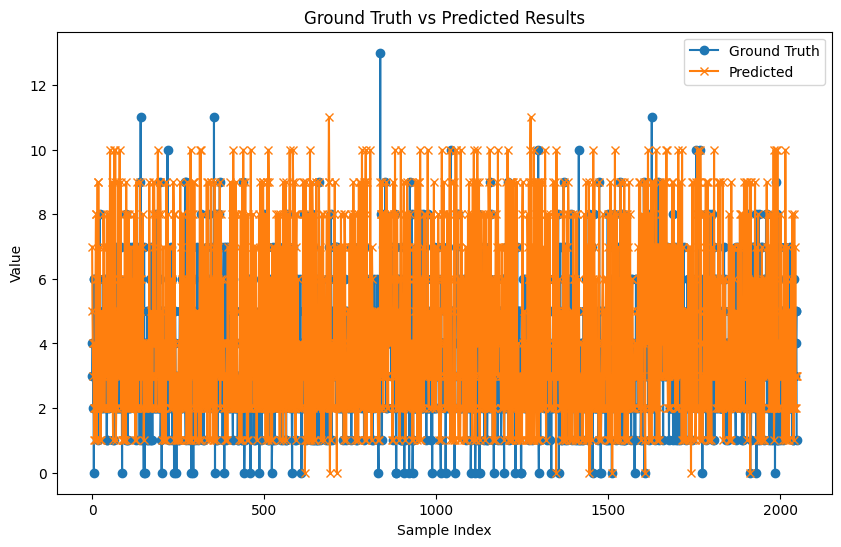

In [45]:
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are already defined as numpy arrays from the evaluation loop

# Plot ground truth vs predicted results
plt.figure(figsize=(10, 6))
plt.plot(res_gs, label='Ground Truth', marker='o')
plt.plot(res_pred, label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Ground Truth vs Predicted Results')
plt.legend()
plt.show()

## Evaluate on Test Dataset

In [50]:
# TODO complete evaluation of the model

res_gs = []
res_pred = []


for batch in test_data_loader_with_padding:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(inputs)

    # res_gs.extend(labels.to(device).numpy())
    # res_pred.extend(outputs.to(device).detach().numpy())
    
    preds = torch.round(outputs)
    # # Store ground truth and predictions
    res_gs.extend(labels.to(device))
    res_pred.extend(preds.detach().to(device))
    


# Convert lists to numpy arrays for further analysis
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)



# Calculate regression metrics
mse = mean_squared_error(res_gs, res_pred)
mae = mean_absolute_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared : {r2:.4f}")

MSE: 6.9629
MAE: 2.0254
R-squared : -0.7789


In [51]:
# Log model parameters for padded dataset evaluation
logger.info("\nEvaluation Results with Padded Train Dataset:")
logger.info(f'Hidden Size: {hidden_size}')
logger.info(f'LSTM Layers: {num_layers}')
logger.info(f'Learning Rate: {learning_rate}')
logger.info(f'Dropout: {dropout}')

# Log evaluation metrics for padded dataset
logger.info(f"Mean Squared Error (MSE) with padding: {mse:.4f}")
logger.info(f"Mean Absolute Error (MAE) with padding: {mae:.4f}")
logger.info(f"R-squared with padding: {r2:.4f}")

2025-01-21 04:21:01,375 - CpG_Detector - INFO - 
Evaluation Results with Padded Train Dataset:
2025-01-21 04:21:01,378 - CpG_Detector - INFO - Hidden Size: 182
2025-01-21 04:21:01,380 - CpG_Detector - INFO - LSTM Layers: 3
2025-01-21 04:21:01,382 - CpG_Detector - INFO - Learning Rate: 0.00029717672681433286
2025-01-21 04:21:01,382 - CpG_Detector - INFO - Dropout: 0.13181082181497766
2025-01-21 04:21:01,383 - CpG_Detector - INFO - Mean Squared Error (MSE) with padding: 6.9629
2025-01-21 04:21:01,384 - CpG_Detector - INFO - Mean Absolute Error (MAE) with padding: 2.0254
2025-01-21 04:21:01,385 - CpG_Detector - INFO - R-squared with padding: -0.7789


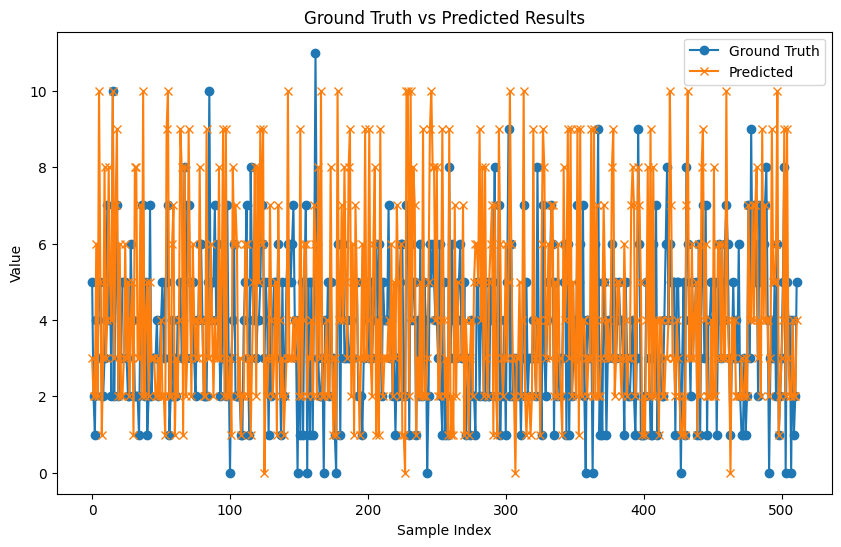

In [52]:
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are already defined as numpy arrays from the evaluation loop

# Plot ground truth vs predicted results
plt.figure(figsize=(10, 6))
plt.plot(res_gs, label='Ground Truth', marker='o')
plt.plot(res_pred, label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Ground Truth vs Predicted Results')
plt.legend()
plt.show()

In [53]:
# Log model parameters for padded dataset evaluation
logger.info("\nEvaluation Results with Padded Test Dataset:")
logger.info(f'Hidden Size: {hidden_size}')
logger.info(f'LSTM Layers: {num_layers}')
logger.info(f'Learning Rate: {learning_rate}')
logger.info(f'Dropout: {dropout}')

# Log evaluation metrics for padded dataset
logger.info(f"Mean Squared Error (MSE) with padding: {mse:.4f}")
logger.info(f"Mean Absolute Error (MAE) with padding: {mae:.4f}")
logger.info(f"R-squared with padding: {r2:.4f}")

2025-01-21 04:21:40,542 - CpG_Detector - INFO - 
Evaluation Results with Padded Test Dataset:
2025-01-21 04:21:40,544 - CpG_Detector - INFO - Hidden Size: 182
2025-01-21 04:21:40,545 - CpG_Detector - INFO - LSTM Layers: 3
2025-01-21 04:21:40,546 - CpG_Detector - INFO - Learning Rate: 0.00029717672681433286
2025-01-21 04:21:40,546 - CpG_Detector - INFO - Dropout: 0.13181082181497766
2025-01-21 04:21:40,547 - CpG_Detector - INFO - Mean Squared Error (MSE) with padding: 6.9629
2025-01-21 04:21:40,548 - CpG_Detector - INFO - Mean Absolute Error (MAE) with padding: 2.0254
2025-01-21 04:21:40,549 - CpG_Detector - INFO - R-squared with padding: -0.7789
